In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import ipywidgets as widgets
from ipywidgets import interactive, VBox, HBox, Layout

In [2]:
class Agent:
    def __init__(self, x, y, state='S', mobility=0.5, assigned_area=None):
        self.x = x
        self.y = y
        self.vx = (np.random.rand() - 0.5) * 2
        self.vy = (np.random.rand() - 0.5) * 2
        self.state = state  # 'S', 'E', 'I', 'R', 'D' VALUES
        self.time_in_state = 0
        self.radius = 3
        self.mobility = mobility
        self.assigned_area = assigned_area
        self.group_id = np.random.randint(0, 10)

    def update_state(self, params, model_type):
        self.time_in_state += 1

        # Probabilistic state transitions per time step
        if self.state == 'E' and np.random.rand() < params['incubation_rate']:
            self.state = 'I'
            self.time_in_state = 0
        elif self.state == 'I' and np.random.rand() < params['recovery_rate']:
            if 'D' in model_type and np.random.rand() < params['death_rate']:
                self.state = 'D'
            else:
                self.state = 'R'
            self.time_in_state = 0
        elif self.state == 'R' and 'S' in model_type and np.random.rand() < params['immunity_loss']:
            self.state = 'S'
            self.time_in_state = 0

    def apply_movement_pattern(self, canvas_dims, agents, params, pattern):
        width, height = canvas_dims
        mobility_factor = self.mobility * (1 - params['social_distancing'])

        if pattern == 'random':
            self.vx += (np.random.rand() - 0.5) * 0.1 * mobility_factor
            self.vy += (np.random.rand() - 0.5) * 0.1 * mobility_factor

        elif pattern == 'commuter':
            stream_direction = 1 if np.floor(self.y / (height / 5)) % 2 == 0 else -1
            self.vx += stream_direction * 0.02 * mobility_factor
            self.vy += (np.random.rand() - 0.5) * 0.05 * mobility_factor

    def update_position(self, canvas_dims, agents, params, movement_pattern):
        if self.state == 'D':
            return

        width, height = canvas_dims
        self.apply_movement_pattern(canvas_dims, agents, params, movement_pattern)

        # Interaction distance defination
        if params['social_distancing'] > 0:
            for other in agents:
                if other is not self and other.state != 'D':
                    dx, dy = self.x - other.x, self.y - other.y
                    dist = np.sqrt(dx**2 + dy**2)
                    if dist < 20 * params['social_distancing']:
                        force = (20 * params['social_distancing'] - dist) * 0.01
                        self.vx += (dx / dist) * force
                        self.vy += (dy / dist) * force

        self.vx *= 0.95  # Friction values , TODO: tell sm1 to find optimal
        self.vy *= 0.95

        self.x += self.vx * self.mobility
        self.y += self.vy * self.mobility

        # Boundary collision
        if self.x <= self.radius or self.x >= width - self.radius:
            self.vx *= -0.8
            self.x = np.clip(self.x, self.radius, width - self.radius)
        if self.y <= self.radius or self.y >= height - self.radius:
            self.vy *= -0.8
            self.y = np.clip(self.y, self.radius, height - self.radius)

    def check_infection(self, agents, params, model_type):
        if self.state != 'S':
            return

        for other in agents:
            if other.state == 'I':
                dist = np.sqrt((self.x - other.x)**2 + (self.y - other.y)**2)
                if dist < 15: # Infection radius
                    infection_chance = params['transmission_rate'] * (1 - params['social_distancing'] * 0.7)
                    if np.random.rand() < infection_chance:
                        self.state = 'E' if 'E' in model_type else 'I'
                        self.time_in_state = 0
                        break

In [3]:
class Simulation:
    def __init__(self, params, model_type='SEIR', movement_pattern='random', canvas_dims=(600, 400)):
        self.params = params
        self.model_type = model_type
        self.movement_pattern = movement_pattern
        self.canvas_dims = canvas_dims
        self.agents = self._initialize_agents()
        self.history = {'S': [], 'E': [], 'I': [], 'R': [], 'D': []}
        self.positions_history = []
        self._record_state()

    def _initialize_agents(self):
        agents = []
        pop = self.params['population']

        initial_states = ['S'] * pop

        # Vaccinated
        vaccinated_count = int(pop * self.params['vaccination_rate'])
        for i in range(vaccinated_count):
            initial_states[i] = 'R'

        # Exposed
        if 'E' in self.model_type:
            for i in range(vaccinated_count, vaccinated_count + self.params['initial_exposed']):
                if i < pop: initial_states[i] = 'E'

        # Infected
        start_infected_index = vaccinated_count + self.params['initial_exposed']
        for i in range(start_infected_index, start_infected_index + self.params['initial_infected']):
            if i < pop: initial_states[i] = 'I'

        np.random.shuffle(initial_states)

        for i in range(pop):
            agents.append(Agent(
                x=np.random.rand() * self.canvas_dims[0],
                y=np.random.rand() * self.canvas_dims[1],
                state=initial_states[i],
                mobility=self.params['mobility']
            ))
        return agents

    def _record_state(self):
        counts = {s: 0 for s in ['S', 'E', 'I', 'R', 'D']}
        current_positions = {'S': [], 'E': [], 'I': [], 'R': [], 'D': []}

        for agent in self.agents:
            counts[agent.state] += 1
            if agent.state != 'D':
                current_positions[agent.state].append((agent.x, agent.y))

        for state in self.history:
            self.history[state].append(counts[state])

        self.positions_history.append(current_positions)


    def run_step(self):
        for agent in self.agents:
            agent.update_position(self.canvas_dims, self.agents, self.params, self.movement_pattern)
            agent.check_infection(self.agents, self.params, self.model_type)
            agent.update_state(self.params, self.model_type)
        self._record_state()

    def run_simulation(self, steps):
        for _ in range(steps):
            self.run_step()
            # Stop if the pandemic is over
            if self.history['I'][-1] == 0 and self.history['E'][-1] == 0:
                break

In [4]:
## todo for later? find an intutitive way to inject params , maybe ui input , then suppply as var args?
params = {
    'population': 500,
    'initial_infected': 5,
    'initial_exposed': 20,
    'vaccination_rate': 0.1,
    'transmission_rate': 0.07,
    'incubation_rate': 0.2,   # Probability per step E -> I
    'recovery_rate': 0.05,    # Probability per step I -> R/D
    'death_rate': 0.01,       # Probability of I -> D given recovery event
    'immunity_loss': 0.001,   # Probability per step R -> S
    'mobility': 0.7,
    'social_distancing': 0.2
}


sim = Simulation(params, model_type='SEIRD', movement_pattern='random')
sim.run_simulation(steps=200)

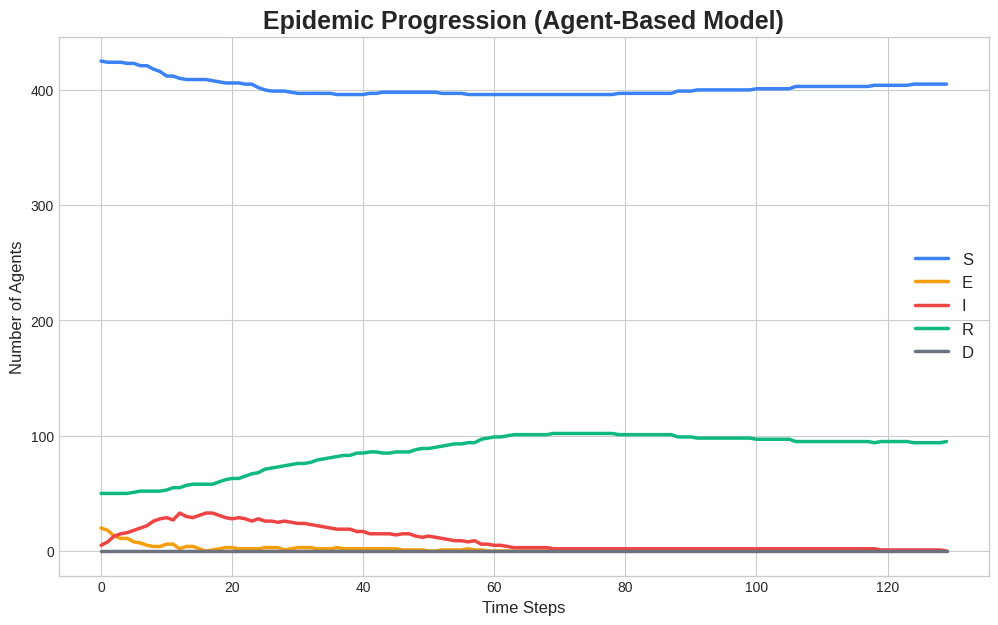

In [5]:
def plot_history(history, model_type):
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))

    colors = {
        'S': '#3b82f6', 'E': '#f59e0b', 'I': '#ef4444',
        'R': '#10b981', 'D': '#6b7280'
    }

    for state, data in history.items():
        if not data: continue
        if state not in model_type and state != 'S': continue
        ax.plot(data, label=state, color=colors[state], linewidth=2.5)

    ax.set_title('Epidemic Progression (Agent-Based Model)', fontsize=18, fontweight='bold')
    ax.set_xlabel('Time Steps', fontsize=12)
    ax.set_ylabel('Number of Agents', fontsize=12)
    ax.legend(fontsize=12)
    ax.grid(True)
    plt.show()

plot_history(sim.history, sim.model_type)

In [9]:
def create_animation(positions_history, canvas_dims):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_facecolor('black')
    ax.set_xlim(0, canvas_dims[0])
    ax.set_ylim(0, canvas_dims[1])
    ax.set_xticks([])
    ax.set_yticks([])
    fig.tight_layout()

    colors = {
        'S': '#3b82f6', 'E': '#f59e0b', 'I': '#ef4444',
        'R': '#10b981', 'D': '#6b7280'
    }

    scatters = {state: ax.scatter([], [], s=15, color=color, label=state)
                for state, color in colors.items()}
    ax.legend(loc='upper right', markerscale=2, facecolor='lightgrey')

    day_text = ax.text(0.02, 0.95, '', color='white', transform=ax.transAxes, fontsize=14)

    def animate(frame):
        positions = positions_history[frame]
        for state, pos_list in positions.items():
            if pos_list:
                pos_array = np.array(pos_list)
                scatters[state].set_offsets(pos_array)
            else:
                scatters[state].set_offsets(np.empty((0, 2)))

        day_text.set_text(f"Day: {frame}")
        return list(scatters.values()) + [day_text]

    anim = FuncAnimation(fig, animate, frames=len(positions_history), interval=50, blit=False)

    plt.close(fig)
    return anim
animation = create_animation(sim.positions_history, sim.canvas_dims)
HTML(animation.to_jshtml())